In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
import rigidbody.transformations as trans
import rigidbody.plotter as plotter
plotter.set_context("paper")

In [3]:
R = trans.rotation_matrix_x(np.pi/3)

In [4]:
R

array([[ 1.       ,  0.       ,  0.       ],
       [ 0.       ,  0.5      , -0.8660254],
       [ 0.       ,  0.8660254,  0.5      ]])

In [5]:
k, theta = trans.axis_angle_from_rot_matrix(R)

In [6]:
k

array([1., 0., 0.])

In [7]:
R = trans.rotation_matrix_z(np.pi/6)@trans.rotation_matrix_y(np.pi/3)@trans.rotation_matrix_z(np.pi/6)

In [8]:
trans.euler_angles_from_rot_matrix(R)*180/np.pi

array([30., 60., 30.])

In [9]:
R = trans.rotation_matrix_z(np.pi/2)@trans.rotation_matrix_y(np.pi/6)@trans.rotation_matrix_x(np.pi/3)

In [10]:
trans.roll_pitch_yaw_angles_from_rot_matrix(R)*180/np.pi

array([90., 30., 60.])

In [11]:
R_10 = trans.rotation_matrix_x(np.pi/2)@trans.rotation_matrix_z(np.pi/2)

In [12]:
R_21 = trans.rotation_matrix_z(np.pi/2)@trans.rotation_matrix_y(np.pi/2)

In [13]:
R_20 = R_10@R_21

In [14]:
R_20

array([[-6.1232340e-17, -1.2246468e-16, -1.0000000e+00],
       [ 1.0000000e+00, -6.1232340e-17, -6.1232340e-17],
       [-6.1232340e-17, -1.0000000e+00,  1.2246468e-16]])

In [15]:
R_10

array([[ 6.12323400e-17, -1.00000000e+00,  0.00000000e+00],
       [ 6.12323400e-17,  3.74939946e-33, -1.00000000e+00],
       [ 1.00000000e+00,  6.12323400e-17,  6.12323400e-17]])

## Homogeneous Transformation

`trans_x` is not commutative with `rot_z`.

In [44]:
trans_x = trans.trans_x(2)
trans_x_inv =  trans.trans_x(-2)
trans_y = trans.trans_y(2)
trans_y_inv = trans.trans_y(-2)
rot_z = trans.rot_z(np.pi/6)

# now if we need to express rotation about z in with the shift center, then A^1_1 = R_z,theta. In frame 0, we should use A^0_0, which is given by (H^1_0)^{-1}A^0_0 H^1_0.
# H^1_0 is frame o0 with respect to o1(after shifting)
rot_z_local = trans_y@rot_z@trans_y_inv

In [17]:
trans_x@rot_z - rot_z@trans_x

array([[ 0.        ,  0.        ,  0.        ,  0.26794919],
       [ 0.        ,  0.        ,  0.        , -1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [18]:
trans_x@trans_y-trans_y@trans_x

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [36]:
def draw_triangles(operations:list,file_name,limits=np.array([[-5,5],[-5,5]])):
    points = np.array([[-1.,-2,0],
    [1,-2,0],
    [0,3,0]])
    middle = np.mean(points,axis=0)
    points[:,0] -= middle[0]
    points[:,1] -= middle[1]
    # frame
    o0 = np.array([[0,0,0.],
                [0.5,0,0.],
                [0,0,0.],
                [0,1,0.]]) # a unit vector at the direction of x0
    frames = []
    frames.append(o0)

    Ps = []
    Ps_ = trans.homogeneous_representation(points)
    Ps.append(Ps_)
    for oper in operations:
        Ps_T = oper@(Ps_.T)
        Ps_ = Ps_T.T
        Ps.append(Ps_)
    

    Po = []
    Po_ = trans.homogeneous_representation(o0)
    Po.append(Po_)
    for oper in operations:
        Po_T = oper@(Po_.T)
        Po_ = Po_T.T
        Po.append(Po_)



    polys=[]
    colors=['red','green','blue','magenta','black','yelllow'] # max 6
    for i,Ps_ in zip(range(len(Ps)),Ps):
        polys.append(Polygon(Ps_[:,:2],fill=False,edgecolor=colors[i])) 


    fig, ax = plt.subplots(1,1,dpi=300)

    for i,poly in zip(range(len(polys)),polys):
        ax.add_patch(poly)
        middle = np.mean(poly.xy[:3,:],axis=0)
        # ax.text(middle[0],middle[1],r'$P^{}$'.format(i))
        ax.scatter(middle[0],middle[1],color=colors[i])

        # draw frame
        Po_i = Po[i]
        plt.arrow(Po_i[0,0],Po_i[0,1],Po_i[1,0]-Po_i[0,0],Po_i[1,1]-Po_i[0,1],color='black',head_width=0.05, head_length=0.1)
        plt.arrow(Po_i[2,0],Po_i[2,1],Po_i[3,0]-Po_i[2,0],Po_i[3,1]-Po_i[2,1],color='black',head_width=0.05, head_length=0.1)
        ax.text(Po_i[1,0],Po_i[1,1],r'$x_{}$'.format(i))
        ax.text(Po_i[3,0],Po_i[3,1],r'$y_{}$'.format(i))

    plt.ylim(*limits[0])
    plt.xlim(*limits[1])
    ax.set_aspect('equal')
    plt.tight_layout()
    # plt.grid(which='both',linewidth=0.5)
    plt.savefig('{}.svg'.format(file_name))

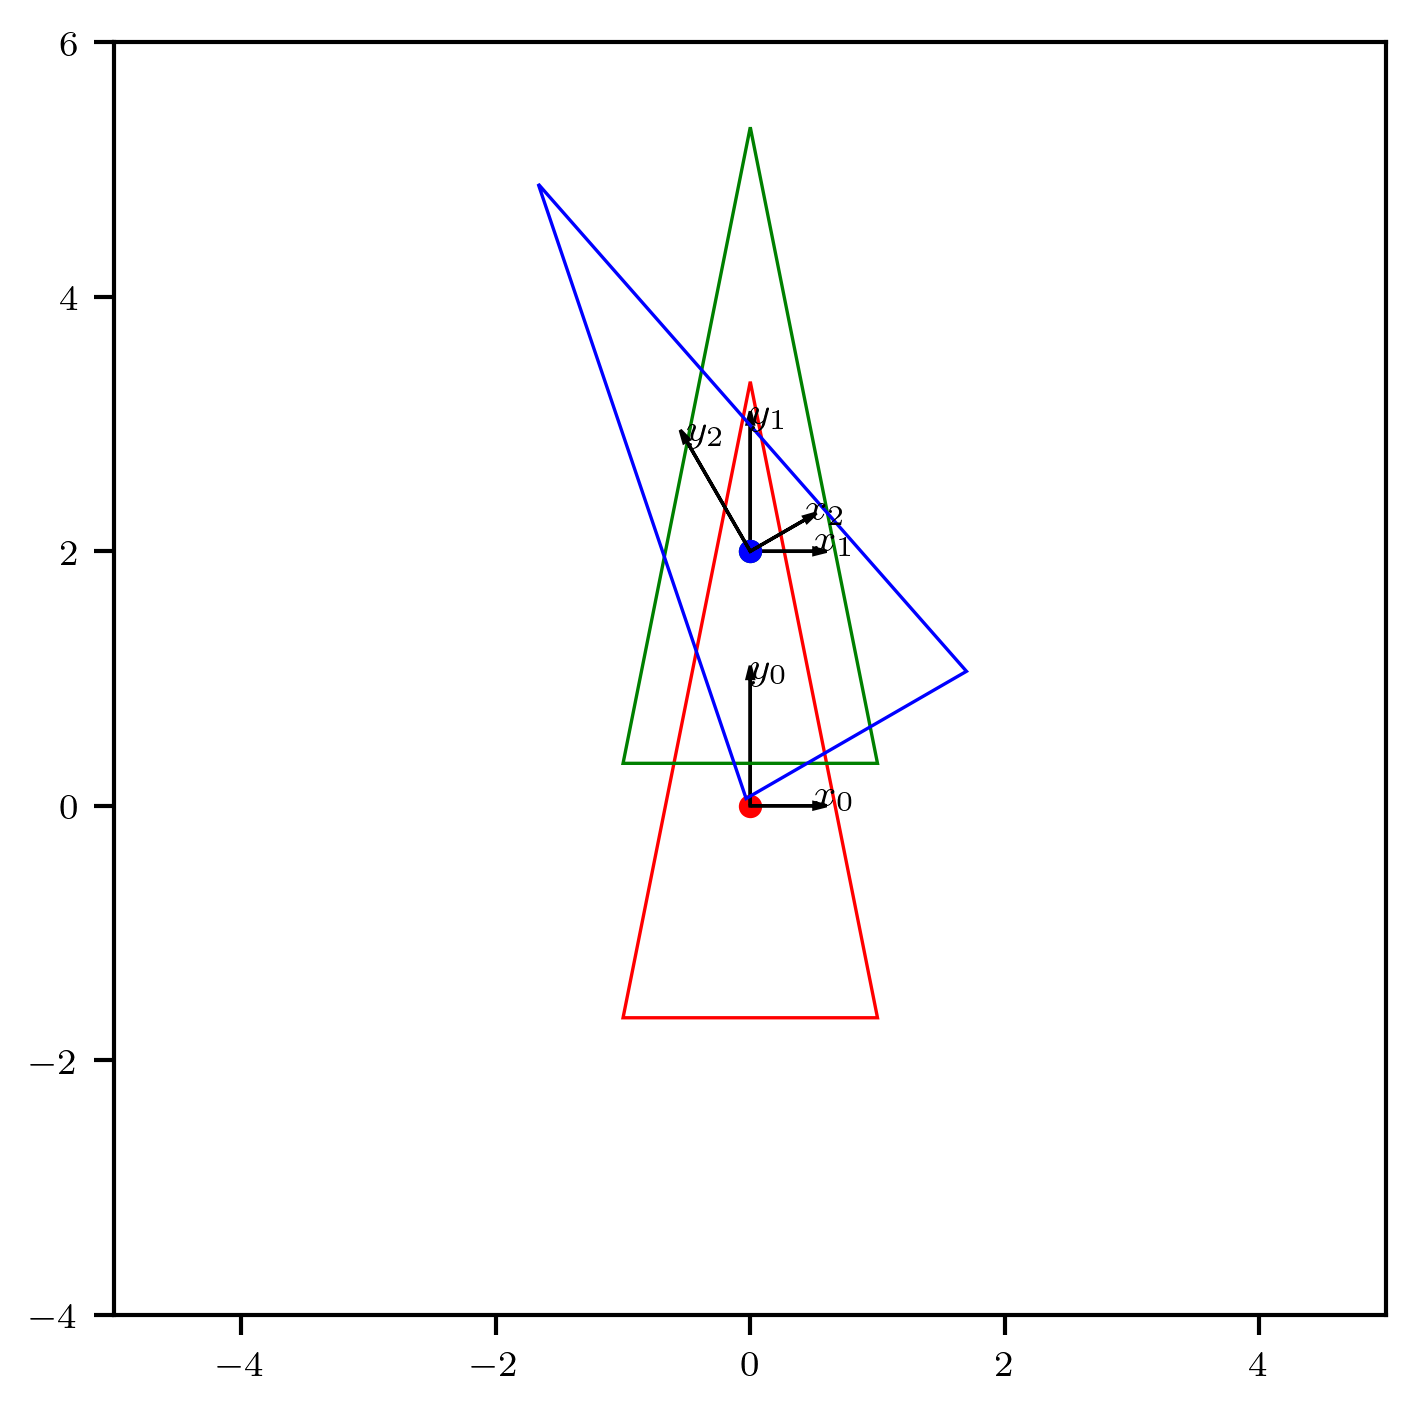

In [51]:
# draw_triangles([trans_x,rot_z],'trans_x_rot_z',limits=np.array([[-4,6],[-5,5]]))
# draw_triangles([rot_z,trans_x],'rot_z_trans_x',limits=np.array([[-4,6],[-5,5]]))
# draw_triangles([trans_y,trans_x],'trans_y_trans_x',limits=np.array([[-4,6],[-5,5]]))
# draw_triangles([trans_x,trans_y],'trans_x_trans_y',limits=np.array([[-4,6],[-5,5]]))
draw_triangles([trans_y,rot_z_local],'trans_y_rot_z_local',limits=np.array([[-4,6],[-5,5]]))